# 성능개선 기법 실습

# 모듈 정의

## train.py
- 모델 학습과 검증 함수 정의

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # 충돌이 되는 library가 있어도 error 발생시키기 마라!

In [2]:
import os
os.makedirs('module', exist_ok=True)

In [94]:
%%writefile module/train.py

import torch
import time

# multi와 binary 정확도 계산이 다르다.

def test_multi_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    다중 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset) # 전체 데이터수
    num_batches = len(dataloader)  #  step 수
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            # 정확도 계산
            pred_label = torch.argmax(pred, axis=-1)
            test_accuracy += torch.sum(pred_label == y).item()
            
        test_loss /= num_batches
        test_accuracy /= size  #전체 개수로 나눈다.
    return test_loss, test_accuracy

def test_binary_classification(dataloader, model, loss_fn, device="cpu") -> tuple:
    """
    이진 분류 검증/평가 함수
    
    [parameter]
        dataloader: DataLoader - 검증할 대상 데이터로더
        model: 검증할 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
    [return]
        tuple: (loss, accuracy)
    """
    model.eval() # 모델을 평가모드로 변환
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, test_accuracy = 0., 0.
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            ## 정확도 계산
            pred_label = (pred >= 0.5).type(torch.int32)
            test_accuracy += (pred_label == y).sum().item() 
            
        test_loss /= num_batches
        test_accuracy /= size   #전체 개수로 나눈다.
    return test_loss, test_accuracy    

def train(dataloader, model, loss_fn, optimizer, device="cpu", mode:"binary or multi"='binary'):
    """
    모델을 1 epoch 학습시키는 함수

    [parameter]
        dataloader: DataLoader - 학습데이터셋을 제공하는 DataLoader
        model - 학습대상 모델
        loss_fn: 모델 추정값과 정답의 차이를 계산할 loss 함수.
        optimizer - 최적화 함수
        device: str - 연산을 처리할 장치. default-"cpu", gpu-"cuda"
        mode: str - 분류 종류. binary 또는 multi
    [return]
        tuple: 학습후 계산한 Train set에 대한  train_loss, train_accuracy
    """
    model.train()

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)

        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if mode == 'binary':
        train_loss, train_accuracy = test_binary_classification(dataloader, model, loss_fn, device)
    else:
        train_loss, train_accuracy = test_multi_classification(dataloader, model, loss_fn, device)
    return train_loss, train_accuracy



def fit(train_loader, val_loader, model, loss_fn, optimizer, epochs, 
        save_best_model=True, save_model_path=None, 
        early_stopping=True, patience=10, 
        device='cpu',  mode:"binary or multi"='binary',
        lr_scheduler=None):
    """
    모델을 학습시키는 함수

    [parameter]
        train_loader (Dataloader): Train dataloader
        test_loader (Dataloader): validation dataloader
        model (Module): 학습시킬 모델
        loss_fn (_Loss): Loss function
        optimizer (Optimizer): Optimizer
        epochs (int): epoch수
        save_best_model (bool, optional): 학습도중 성능개선시 모델 저장 여부. Defaults to True.
        save_model_path (str, optional): save_best_model=True일 때 모델저장할 파일 경로. Defaults to None.
        early_stopping (bool, optional): 조기 종료 여부. Defaults to True.
        patience (int, optional): 조기종료 True일 때 종료전에 성능이 개선될지 몇 epoch까지 기다릴지 epoch수. Defaults to 10.
        device (str, optional): device. Defaults to 'cpu'.
        mode(str, optinal): 분류 종류. "binary(default) or multi
        lr_scheduler (scheduler, optional): learning rate scheduler 객체. Epoch마다 learning rate를 업데이트 시킬 때 사용. Defaults to None.
    [return]
        tuple: 에폭 별 성능 리스트. (train_loss_list, train_accuracy_list, validation_loss_list, validataion_accuracy_list)
    """

    train_loss_list = []
    train_accuracy_list = []
    val_loss_list = []
    val_accuracy_list = []
    
        
    if save_best_model:
        best_score_save = torch.inf

    ############################
    # early stopping
    #############################
    if early_stopping:
        trigger_count = 0
        best_score_es = torch.inf
    
    # 모델 device로 옮기기
    model = model.to(device)
    s = time.time()
    for epoch in range(epochs):
        ### 학습
        train_loss, train_accuracy = train(train_loader, model, loss_fn, optimizer, 
                                            device=device, mode=mode)
        
        ### 학습률 업데이트
        if lr_scheduler:
            lr_scheduler.step()
        
        ### 검증
        if mode == "binary":
            val_loss, val_accuracy = test_binary_classification(val_loader, model, loss_fn, device=device)
        else:
            val_loss, val_accuracy = test_multi_classification(val_loader, model, loss_fn, device=device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
        
        print(f"Epoch[{epoch+1}/{epochs}] - Train loss: {train_loss:.5f} Train Accucracy: {train_accuracy:.5f} || Validation Loss: {val_loss:.5f} Validation Accuracy: {val_accuracy:.5f}")
        print('='*100)
        
        # 모델 저장
        if save_best_model:
            if val_loss < best_score_save: # 성능개선
                torch.save(model, save_model_path)
                print(f"저장: {epoch+1} - 이전 : {best_score_save}, 현재: {val_loss}")
                best_score_save = val_loss
        
        # early stopping 처리            
        if early_stopping:
            if val_loss < best_score_es: # 성능개선
                best_score_es = val_loss  
                trigger_count = 0
                                
            else:
                trigger_count += 1                
                if patience == trigger_count:
                    print(f"Early stopping: Epoch - {epoch}")
                    break
            
    e = time.time()
    print(e-s, "초")
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Overwriting module/train.py


## data.py
- dataset 생성 함수 제공 모듈

In [4]:
%%writefile module/data.py
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def load_mnist_dataset(root_path, batch_size, is_train=True):
    """
    mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader 
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.MNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

def load_fashion_mnist_dataset(root_path, batch_size, is_train=True):
    """
    fashion mnist dataset dataloader 제공 함수
    [parameter]
        root_path: str|Path - 데이터파일 저장 디렉토리
        batch_size: int
        is_train: bool = True - True: Train dataset, False - Test dataset
    [return]
        DataLoader
    """
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = datasets.FashionMNIST(root=root_path, train=is_train, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=is_train)  # shuffle: train이면 True, test면 False 할 것이므로 is_train을 넣음.
    
    return dataloader

Overwriting module/data.py


In [5]:
# %%writefile module/utils.py

import matplotlib.pyplot as plt

def plot_fit_result(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.plot(train_loss_list, label='Train')
    plt.plot(val_loss_list, label='Validation')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.plot(train_acc_list, label='Train')
    plt.plot(val_acc_list, label='Validation')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 하이퍼파라미터, 변수 정의

In [6]:
# import 

import torch
import torch.nn as nn
from torchinfo import summary

from module.train import fit
from module import data

import os
import matplotlib.pyplot as plt

In [7]:
# 데이터 저장할 디렉토리 경로
DATASET_ROOT_PATH = 'datasets'
MODEL_SAVE_ROOT_PATH = 'models'

N_EPOCH = 10
BATCH_SIZE = 256
LR = 0.001

# Data 준비

## mnist 데이터 로딩

In [8]:
train_loader = data.load_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, True)
test_loader = data.load_mnist_dataset(DATASET_ROOT_PATH, BATCH_SIZE, False)

In [9]:
print(train_loader)
print("step수:", len(train_loader))
print("dataset의 shape:", train_loader.dataset.data.shape)
print(train_loader.dataset)

step수: 235
dataset의 shape: torch.Size([60000, 28, 28])
Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


# 모델의 크기 변경에 따른 성능변화

In [10]:
class SizeCheckModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        # input -> output
        self.output = nn.Linear(28*28, 10)  # in: mnist
        
    def forward(self, X):
        out = nn.Flatten()(X)
        out = self.output(out)
        
        return out

In [11]:
model = SizeCheckModel()
summary(model, (256, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SizeCheckModel                           [256, 10]                 --
├─Linear: 1-1                            [256, 10]                 7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 2.01
Input size (MB): 0.80
Forward/backward pass size (MB): 0.02
Params size (MB): 0.03
Estimated Total Size (MB): 0.85

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [13]:
# 학습
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

train_loss_list, train_acc_list, val_loss_list, val_acc_list = \
    fit(train_loader, test_loader, model, loss_fn, optimizer, N_EPOCH, 
        save_best_model=False, early_stopping=False, device=device, mode='multi')

Epoch[1/10] - Train loss: 0.48673 Train Accucracy: 0.88135 || Validation Loss: 0.46263 Validation Accuracy: 0.88930
Epoch[2/10] - Train loss: 0.37987 Train Accucracy: 0.90063 || Validation Loss: 0.36078 Validation Accuracy: 0.90580
Epoch[3/10] - Train loss: 0.33961 Train Accucracy: 0.90858 || Validation Loss: 0.32310 Validation Accuracy: 0.91150
Epoch[4/10] - Train loss: 0.31661 Train Accucracy: 0.91343 || Validation Loss: 0.30317 Validation Accuracy: 0.91550
Epoch[5/10] - Train loss: 0.30299 Train Accucracy: 0.91652 || Validation Loss: 0.29195 Validation Accuracy: 0.91760
Epoch[6/10] - Train loss: 0.29342 Train Accucracy: 0.91908 || Validation Loss: 0.28468 Validation Accuracy: 0.91920
Epoch[7/10] - Train loss: 0.28557 Train Accucracy: 0.92117 || Validation Loss: 0.27691 Validation Accuracy: 0.92250
Epoch[8/10] - Train loss: 0.27892 Train Accucracy: 0.92338 || Validation Loss: 0.27474 Validation Accuracy: 0.92370
Epoch[9/10] - Train loss: 0.27516 Train Accucracy: 0.92358 || Validation

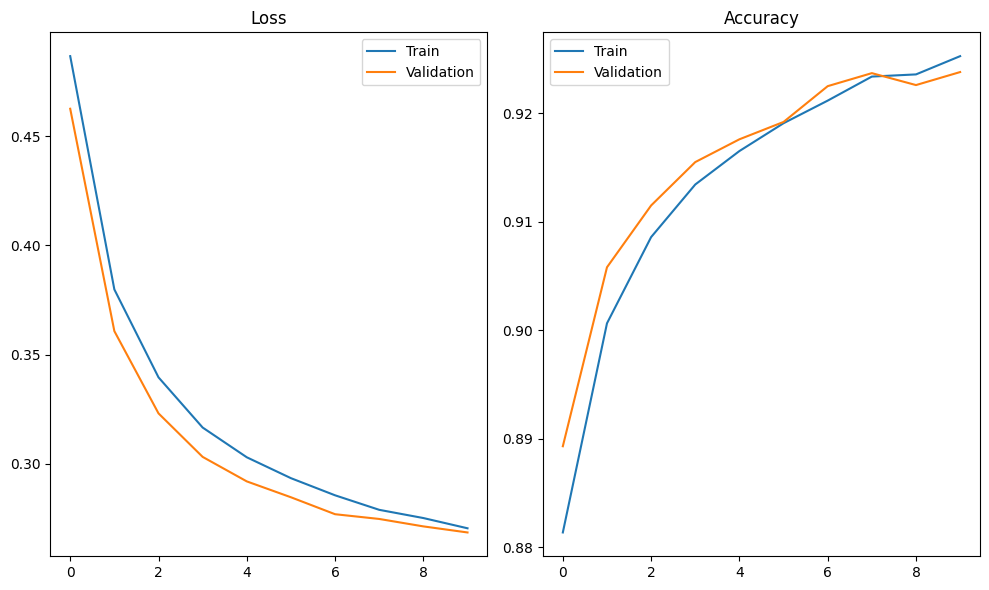

In [14]:
plot_fit_result(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

In [15]:
nn.ReLU()(nn.Linear()(X))

TypeError: Linear.__init__() missing 2 required positional arguments: 'in_features' and 'out_features'

In [ ]:
# Layer block 정의, 단순 순차구조의 모델 정의
# Layer block 정의
bi = nn.Sequential(  # 아래의 내용을 순차적으로 처리
    nn.Linear(64, 32),
        nn.ReLU()
    # nn.Linear(32, 32),
    #     nn.ReLU()
    # nn.Linear(32, 32),
    #     nn.ReLU()
    # nn.Linear(32, 32),
    #     nn.ReLU()
    # nn.Linear(32, 32),
    #     nn.ReLU()
    )

# o = b1(X)
# Sequential()이 아래처럼 순차적으로 처리해서 결과를 return
# t = nn.Linear(64, 32)(X)
# o = nn.ReLU()(t) 

In [ ]:
class SizeCheckModel_2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(28*28, 2048), nn.ReLU())
        self.block2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.block3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.block4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.block5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.block6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        
        self.output = nn.Linear(64, 10)
        
    def forward(self, X):  # 입력 (batch, 1, 28, 28)
        out = nn.Flatten()(X)   # (batch, 1*28*28)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.output(out)
        
        return out

In [ ]:
big_model = SizeCheckModel_2().to(device)
summary(big_model, (BATCH_SIZE, 1 , 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SizeCheckModel_2                         [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─ReLU: 2-2                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-3                       [256, 1024]               2,098,176
│    └─ReLU: 2-4                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-5                       [256, 512]                524,800
│    └─ReLU: 2-6                         [256, 512]                --
├─Sequential: 1-4                        [256, 256]                --
│    └─Linear: 2-7                       [256, 256]                131,328
│    └─ReLU: 2-8                         [256, 256]          

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=LR)

result = fit(train_loader, test_loader, big_model, loss_fn, optimizer, N_EPOCH, 
             save_best_model=False, early_stopping=False,
             device=device, mode='multi')

Epoch[1/10] - Train loss: 0.12292 Train Accucracy: 0.96443 || Validation Loss: 0.12995 Validation Accuracy: 0.96060
Epoch[2/10] - Train loss: 0.08490 Train Accucracy: 0.97410 || Validation Loss: 0.10933 Validation Accuracy: 0.96570
Epoch[3/10] - Train loss: 0.04425 Train Accucracy: 0.98723 || Validation Loss: 0.07790 Validation Accuracy: 0.97680
Epoch[4/10] - Train loss: 0.03275 Train Accucracy: 0.99072 || Validation Loss: 0.06884 Validation Accuracy: 0.97950
Epoch[5/10] - Train loss: 0.04460 Train Accucracy: 0.98597 || Validation Loss: 0.09790 Validation Accuracy: 0.97300
Epoch[6/10] - Train loss: 0.03390 Train Accucracy: 0.98980 || Validation Loss: 0.09360 Validation Accuracy: 0.97560
Epoch[7/10] - Train loss: 0.01766 Train Accucracy: 0.99448 || Validation Loss: 0.08782 Validation Accuracy: 0.97870
Epoch[8/10] - Train loss: 0.02286 Train Accucracy: 0.99345 || Validation Loss: 0.08513 Validation Accuracy: 0.97840
Epoch[9/10] - Train loss: 0.01655 Train Accucracy: 0.99467 || Validation

# Dropout 예제
- dropout 각 레이어에 적용
    - dropout은 nn.Dropout 객체를 사용
    - 객체 생성시 dropout_rate 설정 : 0.2 ~ 0.5
    - Drop시킬 노드를 가진 Layer 뒤에 추가한다.

In [ ]:
x = torch.randn(5, 3)
print(x.shape)
x

torch.Size([5, 3])


tensor([[-1.2981,  1.7604, -0.6784],
        [ 0.3161, -0.5072, -0.7096],
        [ 0.7628,  0.9582, -0.4475],
        [-0.1386, -1.4006, -0.6199],
        [-0.3652, -0.6632,  1.1673]])

In [ ]:
ln_layer = nn.Linear(3, 4)
y = ln_layer(x)
y    # (5 x 4) 출력

tensor([[ 0.0436, -0.8836, -0.5342, -0.4934],
        [ 0.6956,  0.0035, -0.4889, -1.0540],
        [ 0.2247,  0.1832, -0.5924, -0.1182],
        [ 0.8738, -0.1850, -0.3819, -1.5496],
        [-0.0598, -0.2405, -0.1952, -0.3539]], grad_fn=<AddmmBackward0>)

In [ ]:
do_layer = nn.Dropout(0.5)  # 0.5 => drop-out rate (0.5 = 50%)
z = do_layer(y)
z

tensor([[ 0.0872, -1.7673, -1.0683, -0.0000],
        [ 1.3911,  0.0000, -0.0000, -2.1080],
        [ 0.4494,  0.3664, -0.0000, -0.2365],
        [ 0.0000, -0.0000, -0.7637, -3.0991],
        [-0.1195, -0.0000, -0.3904, -0.7078]], grad_fn=<MulBackward0>)

#### MNIST 적용 ####

In [17]:
class DropoutModel(nn.Module):
    
    def __init__(self, drop_rate=None):
        super().__init__()
        
        if not drop_rate:
            drop_rate=0.5
        
        self.block1 = nn.Sequential(nn.Linear(28*28, 2048),
                                    nn.Dropout(p=drop_rate),   # default:  0.5 => 약 50% node를 dropout
                                    nn.ReLU())
        # nn.Dropout(p=0.5)(nn.ReLU()(nn.Linear()(out))) 처럼 해도 됨.
        self.block2 = nn.Sequential(nn.Linear(2048, 1024), nn.ReLU())
        self.block3 = nn.Sequential(nn.Linear(1024, 512), nn.ReLU())
        self.block4 = nn.Sequential(nn.Linear(512, 256), nn.ReLU())
        self.block5 = nn.Sequential(nn.Linear(256, 128), nn.ReLU())
        self.block6 = nn.Sequential(nn.Linear(128, 64), nn.ReLU())
        
        self.output = nn.Linear(64, 10)
        
    def forward(self, X):  # 입력 (batch, 1, 28, 28)
        out = nn.Flatten()(X)   # (batch, 1*28*28)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        out = self.output(out)
        out = nn.Dropout(p=0.5)(out)  # 마지막 출력 layer에 dropout 적용
        
        return out

In [18]:
d_model = DropoutModel(0.5).to(device)
summary(d_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─Dropout: 2-2                      [256, 2048]               --
│    └─ReLU: 2-3                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-4                       [256, 1024]               2,098,176
│    └─ReLU: 2-5                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-6                       [256, 512]                524,800
│    └─ReLU: 2-7                         [256, 512]                --
├─Sequential: 1-4                        [256, 256]                --
│    └─Linear: 2-8                       [256, 256]               

In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(d_model.parameters(), lr=LR)

result = fit(train_loader, test_loader, d_model, loss_fn, optimizer, N_EPOCH, 
            save_best_model=False, early_stopping=False,
            device=device, mode='multi')

Epoch[1/10] - Train loss: 0.97498 Train Accucracy: 0.57717 || Validation Loss: 0.98416 Validation Accuracy: 0.57650
Epoch[2/10] - Train loss: 0.92228 Train Accucracy: 0.58695 || Validation Loss: 0.92117 Validation Accuracy: 0.58630
Epoch[3/10] - Train loss: 0.91468 Train Accucracy: 0.58837 || Validation Loss: 0.90906 Validation Accuracy: 0.59350
Epoch[4/10] - Train loss: 0.90273 Train Accucracy: 0.58923 || Validation Loss: 0.91696 Validation Accuracy: 0.58710
Epoch[5/10] - Train loss: 0.88995 Train Accucracy: 0.59113 || Validation Loss: 0.89817 Validation Accuracy: 0.58790
Epoch[6/10] - Train loss: 0.87949 Train Accucracy: 0.59135 || Validation Loss: 0.88554 Validation Accuracy: 0.59650
Epoch[7/10] - Train loss: 0.88003 Train Accucracy: 0.59387 || Validation Loss: 0.90042 Validation Accuracy: 0.59130
Epoch[8/10] - Train loss: 0.87158 Train Accucracy: 0.59307 || Validation Loss: 0.88792 Validation Accuracy: 0.59650
Epoch[9/10] - Train loss: 0.87816 Train Accucracy: 0.59177 || Validation

In [20]:
d_model2 = DropoutModel(0.3).to(device)
summary(d_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
DropoutModel                             [256, 10]                 --
├─Sequential: 1-1                        [256, 2048]               --
│    └─Linear: 2-1                       [256, 2048]               1,607,680
│    └─Dropout: 2-2                      [256, 2048]               --
│    └─ReLU: 2-3                         [256, 2048]               --
├─Sequential: 1-2                        [256, 1024]               --
│    └─Linear: 2-4                       [256, 1024]               2,098,176
│    └─ReLU: 2-5                         [256, 1024]               --
├─Sequential: 1-3                        [256, 512]                --
│    └─Linear: 2-6                       [256, 512]                524,800
│    └─ReLU: 2-7                         [256, 512]                --
├─Sequential: 1-4                        [256, 256]                --
│    └─Linear: 2-8                       [256, 256]               

In [21]:
result = fit(train_loader, test_loader, d_model2, loss_fn, optimizer, N_EPOCH, 
            save_best_model=False, early_stopping=False,
            device=device, mode='multi')

Epoch[1/10] - Train loss: 2.30539 Train Accucracy: 0.10208 || Validation Loss: 2.30608 Validation Accuracy: 0.09740
Epoch[2/10] - Train loss: 2.30577 Train Accucracy: 0.09972 || Validation Loss: 2.30569 Validation Accuracy: 0.10040
Epoch[3/10] - Train loss: 2.30572 Train Accucracy: 0.10213 || Validation Loss: 2.30705 Validation Accuracy: 0.09720
Epoch[4/10] - Train loss: 2.30577 Train Accucracy: 0.10332 || Validation Loss: 2.30685 Validation Accuracy: 0.10150
Epoch[5/10] - Train loss: 2.30525 Train Accucracy: 0.10440 || Validation Loss: 2.30626 Validation Accuracy: 0.10150
Epoch[6/10] - Train loss: 2.30585 Train Accucracy: 0.10292 || Validation Loss: 2.30697 Validation Accuracy: 0.09650
Epoch[7/10] - Train loss: 2.30560 Train Accucracy: 0.10348 || Validation Loss: 2.30650 Validation Accuracy: 0.09920
Epoch[8/10] - Train loss: 2.30551 Train Accucracy: 0.10298 || Validation Loss: 2.30651 Validation Accuracy: 0.10430
Epoch[9/10] - Train loss: 2.30579 Train Accucracy: 0.10212 || Validation

# Batch Normalization
- Dense => BN => Activation

In [25]:
torch.manual_seed(0)
input_data = torch.rand(10, 5)
bn = nn.BatchNorm1d(5)  # BatchNorm1d() -> X가 1차원일 때
                        # BatchNorm2d() -> X가 2차원일 때
output_data = bn(input_data)

In [26]:
print(input_data.mean(dim=0))
print(input_data.std(dim=0))

tensor([0.4338, 0.6425, 0.4724, 0.3281, 0.3822])
tensor([0.1993, 0.2852, 0.3720, 0.2740, 0.1943])


In [28]:
print(output_data.mean(dim=0))
print(output_data.std(dim=0))
# 평균과 표준편차가 0, 1에 가까워짐. -> feature scaling 효과

tensor([-2.0266e-07, -1.1325e-07, -2.3842e-08,  3.8743e-08,  1.1921e-08],
       grad_fn=<MeanBackward1>)
tensor([1.0539, 1.0540, 1.0541, 1.0540, 1.0539], grad_fn=<StdBackward0>)


### MNIST

In [35]:
# 보통 Linear() -> BNorm() -> ReLU() (-> Dropout()) 순서로 적용

class BNModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(nn.Linear(28*28, 256),
                                    nn.BatchNorm1d(256),    # 앞 layer의 출력 node 수와 동일하게 설정
                                    nn.ReLU(),
                                    )
        self.block2 = nn.Sequential(nn.Linear(256, 128),
                                    nn.BatchNorm1d(128),
                                    nn.ReLU(),
                                    )
        self.block3 = nn.Sequential(nn.Linear(128, 64),
                                    nn.BatchNorm1d(64),
                                    nn.ReLU(),
                                    )
        self.block4 = nn.Sequential(nn.Linear(64, 32),
                                    nn.BatchNorm1d(32),
                                    nn.ReLU(),
                                    )
        self.output = nn.Linear(32, 10)
        
        self.blocks = [self.block1, self.block2, self.block3, self.block4]
        
    def forward(self, X):
        out = nn.Flatten()(X)
        for block in self.blocks:
            out = block(out)
        out = self.output(out)
        return out
        pass

In [36]:
device

'cuda'

In [37]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.001
BATCH_SIZE = 256
N_EPOCH = 10

In [38]:
bn_model = BNModel().to(device)
optimizer = torch.optim.Adam(bn_model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()
summary(bn_model, (BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BNModel                                  [256, 10]                 --
├─Sequential: 1-1                        [256, 256]                --
│    └─Linear: 2-1                       [256, 256]                200,960
│    └─BatchNorm1d: 2-2                  [256, 256]                512
│    └─ReLU: 2-3                         [256, 256]                --
├─Sequential: 1-2                        [256, 128]                --
│    └─Linear: 2-4                       [256, 128]                32,896
│    └─BatchNorm1d: 2-5                  [256, 128]                256
│    └─ReLU: 2-6                         [256, 128]                --
├─Sequential: 1-3                        [256, 64]                 --
│    └─Linear: 2-7                       [256, 64]                 8,256
│    └─BatchNorm1d: 2-8                  [256, 64]                 128
│    └─ReLU: 2-9                         [256, 64]                 --


In [39]:
result_bn = fit(train_loader, test_loader, bn_model, loss_fn, optimizer, N_EPOCH,
                save_best_model=False, early_stopping=False,
                device=device, mode='multi')

Epoch[1/10] - Train loss: 0.12612 Train Accucracy: 0.97682 || Validation Loss: 0.14506 Validation Accuracy: 0.96990
Epoch[2/10] - Train loss: 0.05811 Train Accucracy: 0.98688 || Validation Loss: 0.08630 Validation Accuracy: 0.97540
Epoch[3/10] - Train loss: 0.04060 Train Accucracy: 0.98997 || Validation Loss: 0.07962 Validation Accuracy: 0.97550
Epoch[4/10] - Train loss: 0.03413 Train Accucracy: 0.99052 || Validation Loss: 0.08152 Validation Accuracy: 0.97640
Epoch[5/10] - Train loss: 0.01756 Train Accucracy: 0.99597 || Validation Loss: 0.06584 Validation Accuracy: 0.98000
Epoch[6/10] - Train loss: 0.01634 Train Accucracy: 0.99603 || Validation Loss: 0.06712 Validation Accuracy: 0.97970
Epoch[7/10] - Train loss: 0.01169 Train Accucracy: 0.99700 || Validation Loss: 0.06466 Validation Accuracy: 0.98080
Epoch[8/10] - Train loss: 0.00964 Train Accucracy: 0.99753 || Validation Loss: 0.06891 Validation Accuracy: 0.98010
Epoch[9/10] - Train loss: 0.01055 Train Accucracy: 0.99707 || Validation

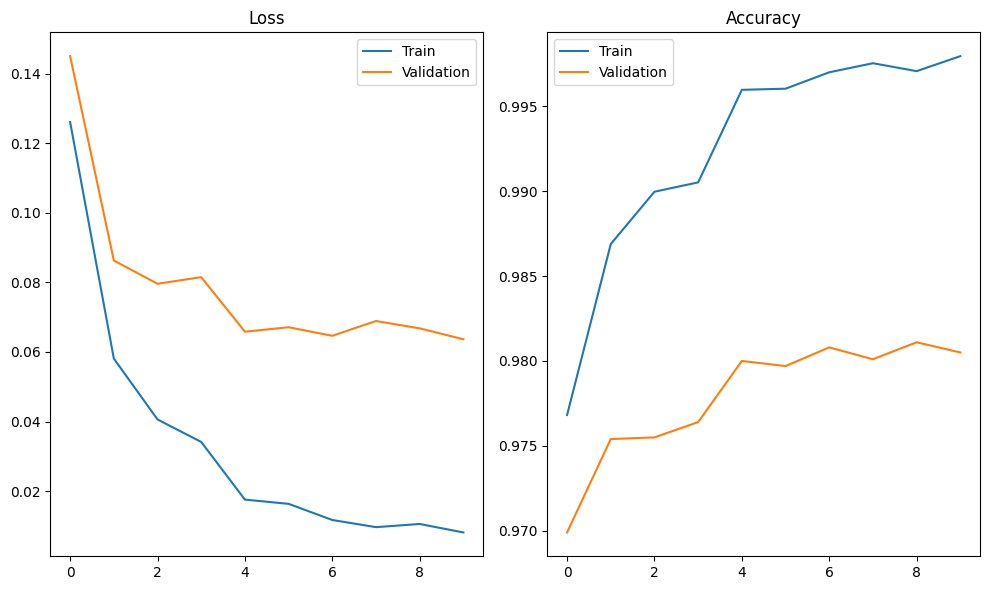

In [40]:
plot_fit_result(*result_bn)

# Learning rate decay

### Optimizer와 Learning rate scheduler의 속성, 메소드 확인
- 파이토치는 `torch.optim` 모듈에서 다양한 Learning rate 알고리즘을 제공한다.

In [43]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=LR)
info_dict = optimizer.param_groups[0]
info_dict.keys()

dict_keys(['params', 'lr', 'betas', 'eps', 'weight_decay', 'amsgrad', 'maximize', 'foreach', 'capturable', 'differentiable', 'fused'])

In [44]:
info_dict['lr']

0.001

In [45]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=LR)
# scheduler가 optimizer의 lr을 학습 도중에 변경시킴.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)  # step_size: 몇 epoch마다 lr을 변경할지

In [47]:
# 현재 optimizer의 lr
optimizer.param_groups[0]['lr'], scheduler.get_last_lr()

(0.001, [0.001])

In [51]:
#### 학습률 변화 흐름을 그래프로 그려주는 함수
def plot_lr(name, lr_list):
    # name: 스케줄러 이름
    # lr_list: 스케줄러가 변경한 lr 리스트
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(lr_list)), lr_list, label=name)
    
    plt.title(f"Scheudler: {name}")
    x_tick = [ x for x in range(len(lr_list)) if x % 5 == 0]
    plt.xticks(x_tick, rotation=45)
    plt.xlabel("Epoch")
    plt.ylabel("Learning rate")
    plt.grid(True, axis='x', alpha=0.5, linestyle='--')
    plt.show()

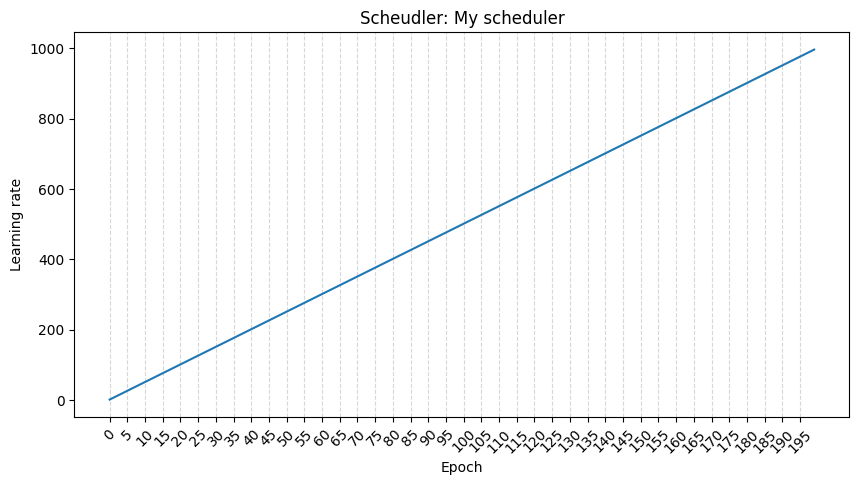

In [54]:
plot_lr("My scheduler", list(range(1,1000,5)))

#### StepLR

In [66]:
optimizer = torch.optim.Adam(bn_model.parameters(), lr=LR)
step_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,     # 학습률을 변경할 optimizer
                                                step_size=25,    # 몇 epoch마다 변경할지
                                                gamma=0.5,      # 학습률을 얼마나 변경시킬지의 비율
                                                )


In [67]:
step_size = 3
gamma = 0.5
f'optimizer의 gkrtmqfbfdmf {step_size}에폭마다 lr을 {gamma}배씩 변경. lr * gamma = {LR*gamma} => 새로운 lr'

'optimizer의 gkrtmqfbfdmf 3에폭마다 lr을 0.5배씩 변경. lr * gamma = 0.0005 => 새로운 lr'

In [88]:
N_EPOCH = 100
STEP_SIZE = 10
lr_list = []
for i in range(N_EPOCH):
    #학습은 배치단위로 진행
    for _ in range(STEP_SIZE):
        # 추정 -> loss 계산 -> 역전파 -> 가중치 갱신
        optimizer.step()
    # 한 epoch이 끝나면 scheduler에게 알려줌.
    # learning rate을 변경할지 여부를 scheduler에게 물어봄.
    step_scheduler.step()
    # 변경된 learning rate을 저장
    lr_list.append(step_scheduler.get_last_lr()[0])

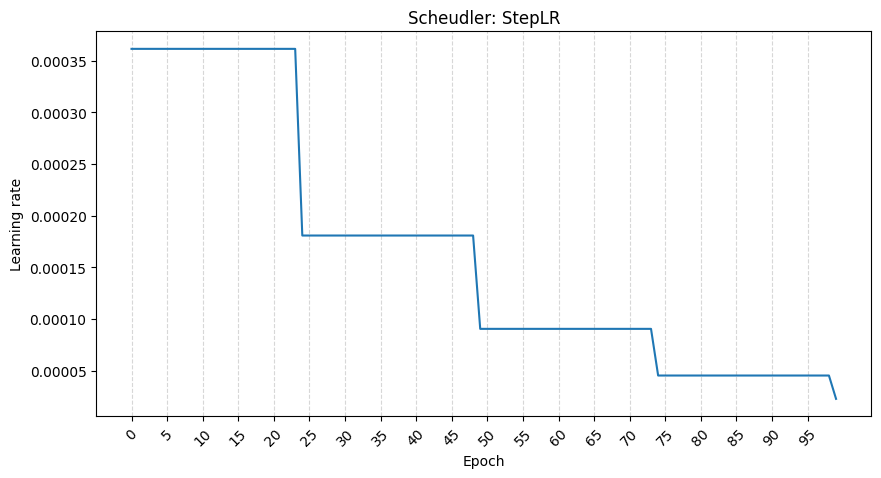

In [89]:
plot_lr("StepLR", lr_list)

#### CosineAnnealingLR
cosine 그래프를 그리면서 learning rate를 변경 하는 방식.  
최근에는 learning rate를 단순히 감소시키기 보다는 감소와 증가를 반복하여 진동하는 방식으로 최적점을 찾아가는 알고리즘을 많이 사용한다. 이러한 방법 중 가장 간단하면서도 많이 사용되는 방법이 CosineAnnealingLR이다.

In [90]:
# Annealing - 가열, 냉각
ca_schrduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                        T_max=10,  # T_max: 몇 epoch 간격으로 반복할지
                                                        eta_min=0.00001,  # 최소 학습률
                                                        )

lr_list2 = []

for i in range(N_EPOCH):
    for _ in range(STEP_SIZE):
        optimizer.step()
    ca_schrduler.step()
    lr_list2.append(ca_schrduler.get_last_lr()[0])

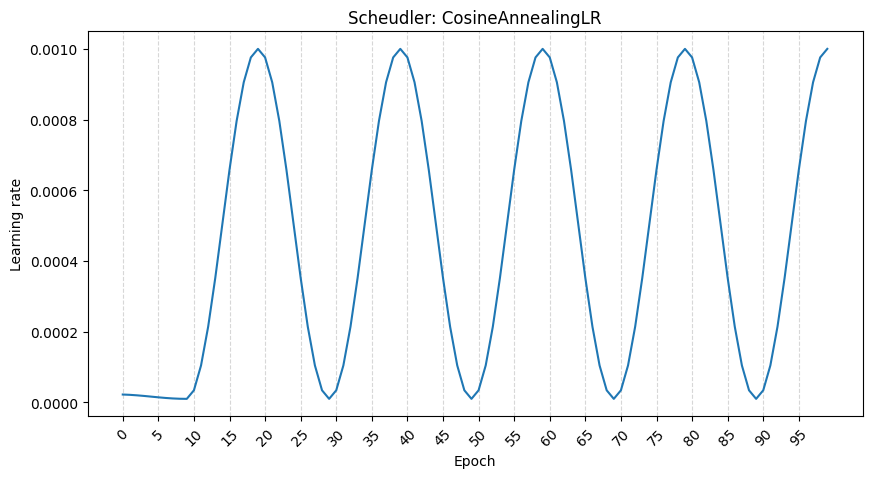

In [91]:
plot_lr("CosineAnnealingLR", lr_list2)

#### CosineAnnealingWarmRestarts

cosine annealing의 스케쥴링에 cosine 주기의 에폭을 점점 늘리거나 줄일 수 있다. (보통 늘린다.)

In [92]:
care_schrduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                                        T_0=10,     # T_0: 몇 epoch 간격으로 반복할지 (초기 사이클 주기)
                                                                        T_mult=2,  # T_0를 몇 배씩 증가시킬지
                                                                        eta_min=0.00001,  # 최소 학습률
                                                                        )

lr_list3 = []
for i in range(N_EPOCH):
    for _ in range(STEP_SIZE):
        optimizer.step()
    care_schrduler.step()
    lr_list3.append(care_schrduler.get_last_lr()[0])

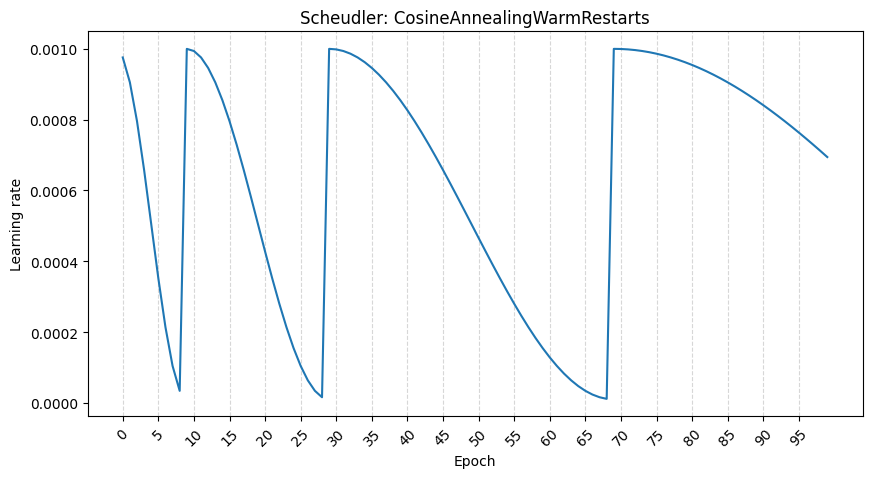

In [93]:
plot_lr("CosineAnnealingWarmRestarts", lr_list3)